In [2]:
import json

import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
import numpy as np
%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
in_file = "/home/adrian/workspace/qa-generator-with-human-review/data/generated/merged_qa_pairs.json"
# load all question answer pairs
with open(in_file, "r") as f:
    qa_pairs = json.load(f)
    questions = [qa["question"] for qa in qa_pairs]
    answers = [qa["answer"] for qa in qa_pairs]

print(f"Number of question-answer pairs: {len(qa_pairs)}")

Number of question-answer pairs: 2372


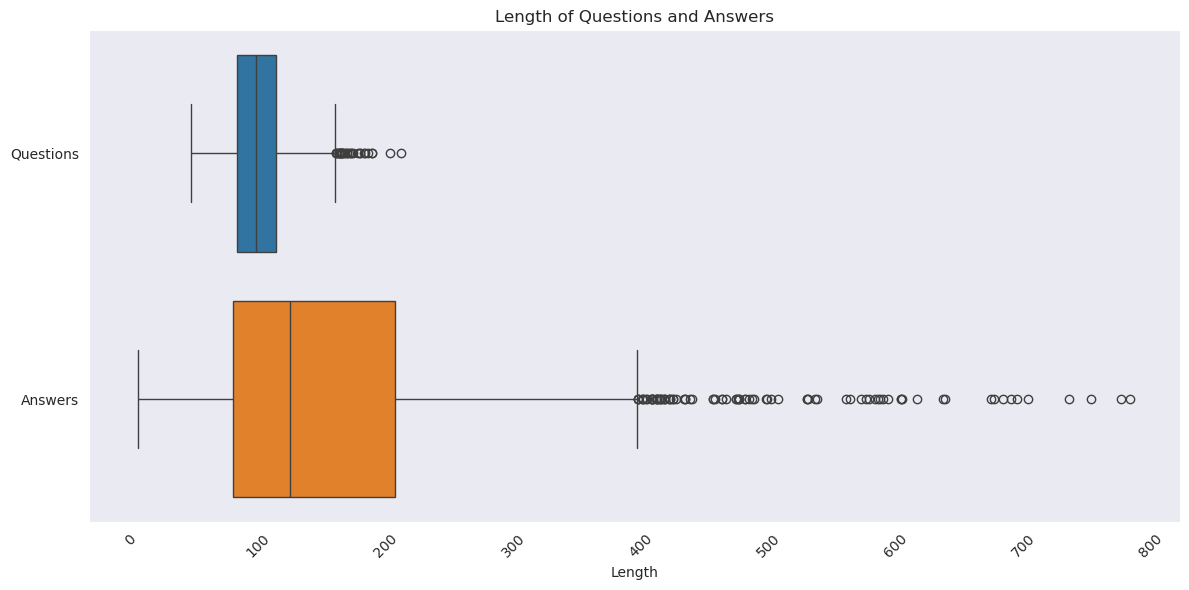

In [4]:
# compute char lengths of questions and answers
questions_lengths = [len(q) for q in questions]
answers_lengths = [len(a) for a in answers]

# box plot of question and answer lengths
plt.figure(figsize=(12, 6))
sns.boxplot(data=[questions_lengths, answers_lengths], orient="h")
plt.xlabel("Length")
plt.xticks(rotation=45)
plt.yticks([0, 1], ["Questions", "Answers"])
plt.title("Length of Questions and Answers")
plt.grid(axis="x")
plt.tight_layout()

In [5]:
# compute question and answers embeddings
st = SentenceTransformer("all-MiniLM-L12-v2")
questions_embeddings = st.encode(questions, show_progress_bar=True)
answers_embeddings = st.encode(answers, show_progress_bar=True)

Batches:   0%|          | 0/75 [00:00<?, ?it/s]

Batches:   0%|          | 0/75 [00:00<?, ?it/s]

In [6]:
# compute t-sne of question and answer embeddings
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
questions_tsne = tsne.fit_transform(questions_embeddings)
answers_tsne = tsne.fit_transform(answers_embeddings)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


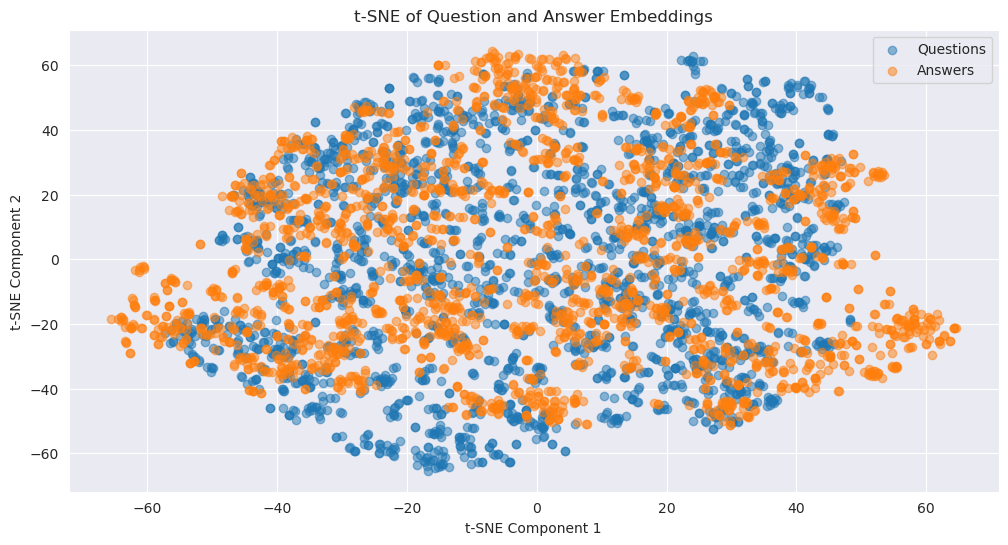

In [7]:
# plot t-sne of question and answer embeddings
plt.figure(figsize=(12, 6))
plt.scatter(questions_tsne[:, 0], questions_tsne[:, 1], label="Questions", alpha=0.5)
plt.scatter(answers_tsne[:, 0], answers_tsne[:, 1], label="Answers", alpha=0.5)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE of Question and Answer Embeddings")
plt.legend()

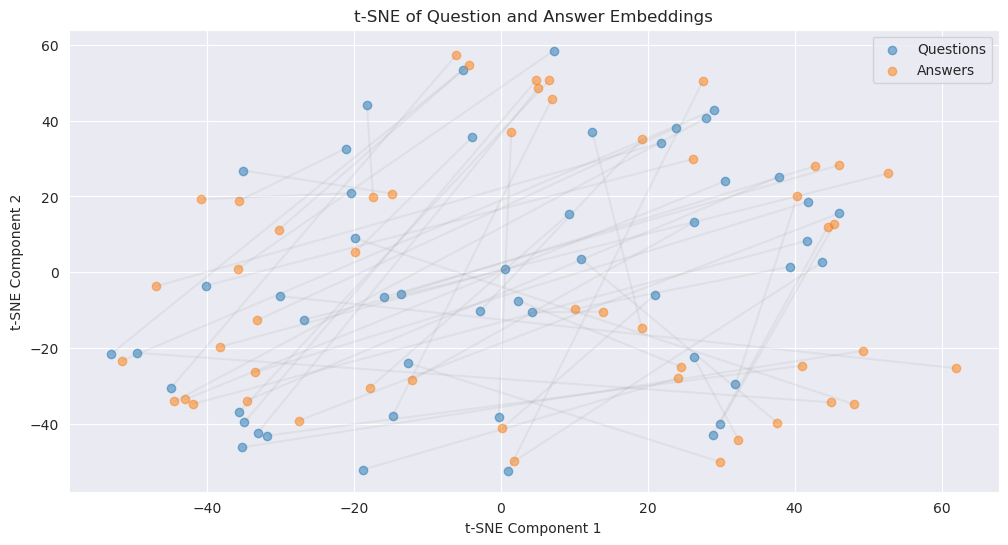

In [8]:
# select 50 random questions and answers for visualization
rand_size = 50
np.random.seed(42)
selected_indices = np.random.choice(len(questions), size=rand_size, replace=False)
questions_tsne_selected = questions_tsne[selected_indices]
answers_tsne_selected = answers_tsne[selected_indices]
# plot t-sne of question and answer embeddings
plt.figure(figsize=(12, 6))
plt.scatter(questions_tsne_selected[:, 0], questions_tsne_selected[:, 1], label="Questions", alpha=0.5)
plt.scatter(answers_tsne_selected[:, 0], answers_tsne_selected[:, 1], label="Answers", alpha=0.5)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE of Question and Answer Embeddings")
plt.legend()
# connect corresponding question and answer points
for i in range(len(questions_tsne_selected)):
    plt.plot([questions_tsne_selected[i, 0], answers_tsne_selected[i, 0]], 
             [questions_tsne_selected[i, 1], answers_tsne_selected[i, 1]], 
             color='gray', alpha=0.1)

In [9]:
# print 20 random questions and answers
import random
random.seed(42)
sampled_indices = random.sample(range(len(questions)), 20)
for i in sampled_indices:
    print(f"Question: {questions[i]}")
    print(f"Answer: {answers[i]}")
    print("-" * 80)

Question: What regulatory powers does the German resolution authority have concerning the Notes issued by the Issuer?
Answer: The German resolution authority has the power to suspend any payment obligations of the Issuer or to modify the terms and conditions of the Notes.
--------------------------------------------------------------------------------
Question: What are the initial terms and conditions for investing in the securities being offered?
Answer: The initial emission price is 100,00 % of the nominal amount, and the securities can be acquired from banks and savings banks with a minimum purchase of one security with a nominal value of 1,000 Euro, possibly against payment of usual bank fees.
--------------------------------------------------------------------------------
Question: What is the target portfolio size for NORD/LB in 2018?
Answer: The target portfolio size for NORD/LB in 2018 is between EUR 12 billion and EUR 14 billion.
----------------------------------------------

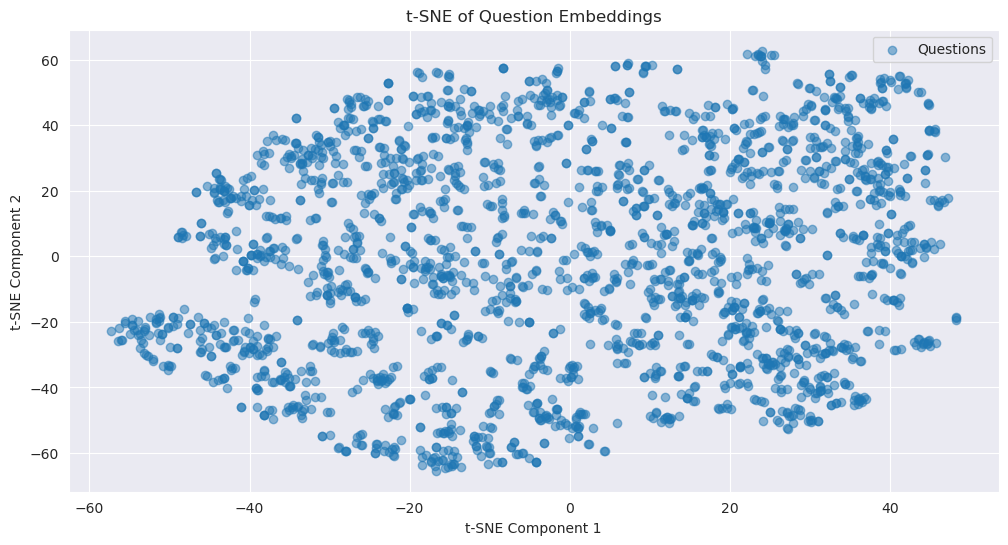

In [10]:
# show t-sne of questions embeddings only
plt.figure(figsize=(12, 6))
plt.scatter(questions_tsne[:, 0], questions_tsne[:, 1], label="Questions", alpha=0.5)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE of Question Embeddings")
plt.legend()

Text(0.5, 1.0, 'Word Cloud of Questions')

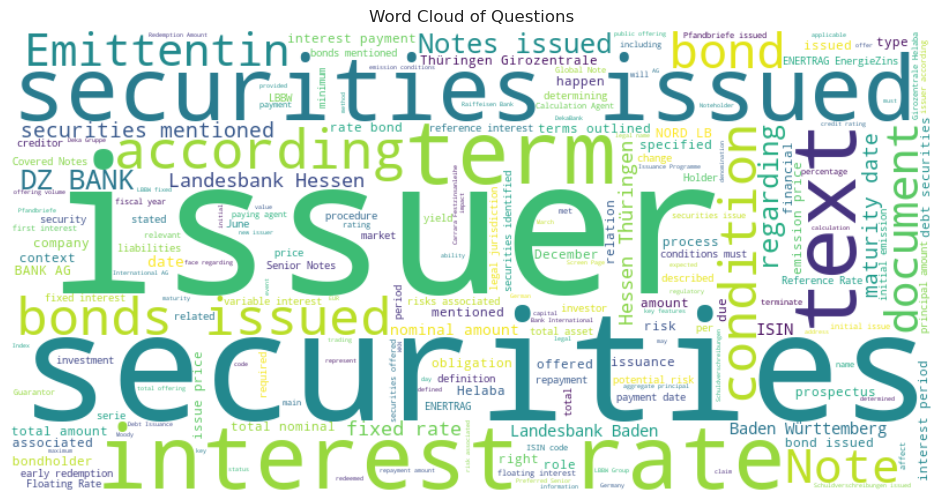

In [12]:
# show wordcloud for questions
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(questions))
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Questions")

In [17]:
# shot top 10 clusters according to size filter cluster with label -1
clusters, counts = np.unique(questions_clusters, return_counts=True)
cluster_sizes = dict(zip(clusters, counts))
top_clusters = sorted(cluster_sizes.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 clusters by size:")
for cluster, size in top_clusters:
    print(f"Cluster {cluster}: {size} questions")

Top 10 clusters by size:
Cluster -1: 1621 questions
Cluster 58: 28 questions
Cluster 75: 28 questions
Cluster 45: 23 questions
Cluster 22: 20 questions
Cluster 24: 19 questions
Cluster 33: 18 questions
Cluster 59: 18 questions
Cluster 64: 18 questions
Cluster 76: 16 questions


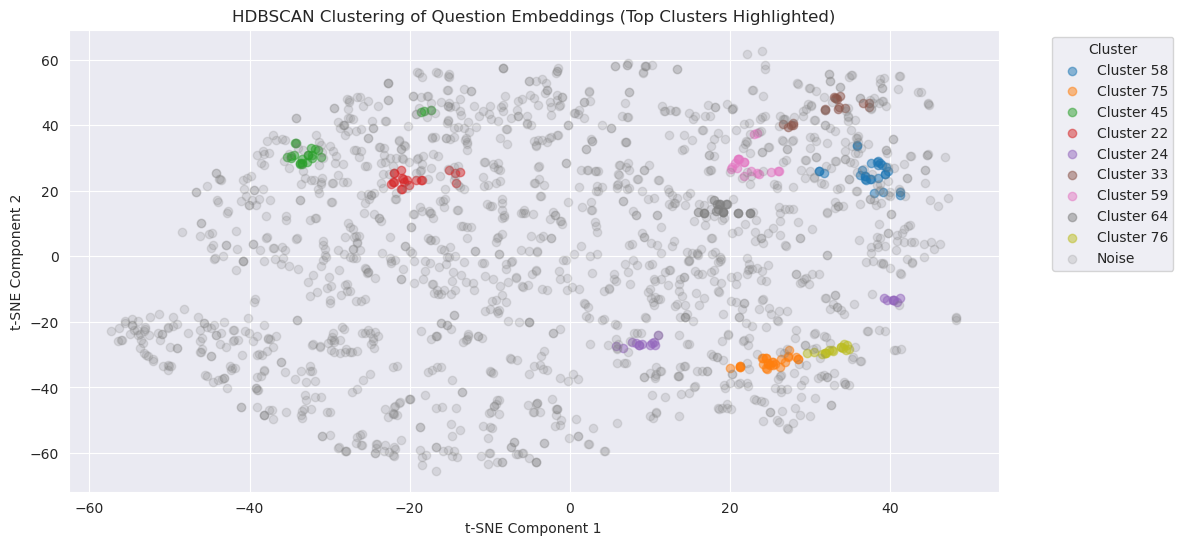

In [24]:
# show t-sne embeddings with top clusters highlighted and the rest in gray
plt.figure(figsize=(12, 6))
for cluster, size in top_clusters:
    if cluster == -1:
        continue
    cluster_indices = np.where(questions_clusters == cluster)[0]
    plt.scatter(questions_tsne[cluster_indices, 0], questions_tsne[cluster_indices, 1], label=f"Cluster {cluster}", alpha=0.5)
plt.scatter(questions_tsne[questions_clusters == -1, 0], questions_tsne[questions_clusters == -1, 1], color='gray', alpha=0.2, label="Noise")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("HDBSCAN Clustering of Question Embeddings (Top Clusters Highlighted)")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc=2)


In [20]:
# show key phrases for each cluster
from keybert import KeyBERT
kw_model = KeyBERT()

for cluster, _ in top_clusters:
    if cluster == -1:
        continue
    cluster_questions = [questions[i] for i in range(len(questions)) if questions_clusters[i] == cluster]
    if not cluster_questions:
        continue
    print(f"Cluster {cluster} key phrases:")
    key_phrases = kw_model.extract_keywords(' '.join(cluster_questions), keyphrase_ngram_range=(1, 2), stop_words=None)
    key_phrases = sorted(key_phrases, key=lambda x: x[1], reverse=True)[:5]
    for phrase, score in key_phrases:
        print(f"  {phrase} (score: {score:.4f})")
    print("-" * 80)
    

Cluster 58 key phrases:
  interest rate (score: 0.5568)
  bonds issued (score: 0.5560)
  bond issued (score: 0.5308)
  interest payment (score: 0.4788)
  secured bonds (score: 0.4643)
--------------------------------------------------------------------------------
Cluster 75 key phrases:
  mortgage bonds (score: 0.4950)
  bonds issued (score: 0.4411)
  public bonds (score: 0.3887)
  landesbank baden (score: 0.3806)
  württemberg what (score: 0.3700)
--------------------------------------------------------------------------------
Cluster 45 key phrases:
  bondholders and (score: 0.6189)
  bondholders according (score: 0.6104)
  bondholders (score: 0.5930)
  of bondholders (score: 0.5766)
  do bondholders (score: 0.5742)
--------------------------------------------------------------------------------
Cluster 22 key phrases:
  allow bondholders (score: 0.4945)
  bonds issued (score: 0.4600)
  bondholders can (score: 0.4408)
  bondholders (score: 0.4394)
  bond according (score: 0.4390)
--

Text(0.5, 1.0, 'Word Cloud of Cluster 58 Questions')

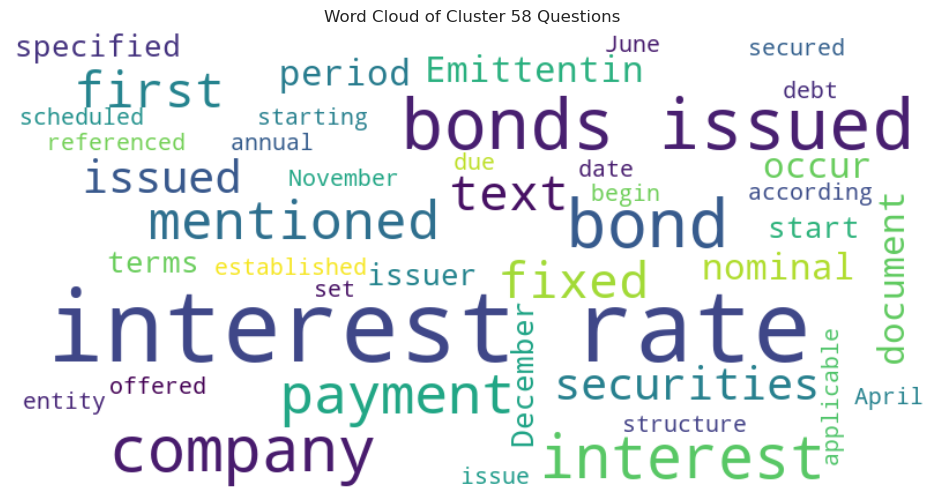

In [21]:
# show wordcloud for cluster 58
cluster_58_questions = [questions[i] for i in range(len(questions)) if questions_clusters[i] == 58]
wordcloud_58 = WordCloud(width=800, height=400, background_color='white').generate(' '.join(cluster_58_questions))
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_58, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Cluster 58 Questions")


Text(0.5, 1.0, 'Word Cloud of Cluster 24 Questions')

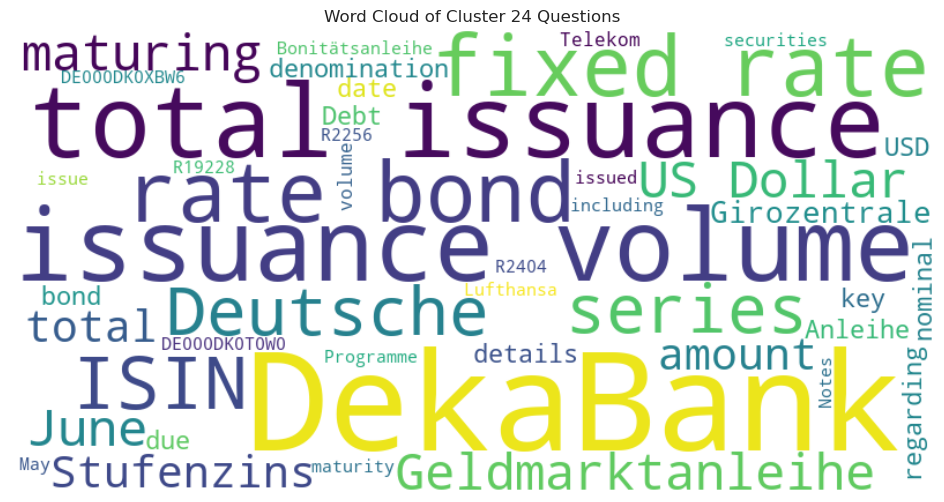

In [22]:
# show wordcloud for cluster 24
cluster_24_questions = [questions[i] for i in range(len(questions)) if questions_clusters[i] == 24]
wordcloud_24 = WordCloud(width=800, height=400, background_color='white').generate(' '.join(cluster_24_questions))
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_24, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Cluster 24 Questions")